In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle

import numpy as np
import numpy.lib.recfunctions as rfn

import matplotlib.pyplot as plt
import scipy.integrate, scipy.interpolate, scipy.stats

from astropy.table import Table

- Some of the calculation here also depends on the `awesome_cluster_finder` package by Christopher Bradshaw
    - It will be available [in this Github repo](https://github.com/Christopher-Bradshaw/awesome_cluster_finder)

- If you don't have access to `acf` or don't have space for downloading the data, you can load the saved data in this folder to reproduce the figure.


In [2]:
import awesome_cluster_finder as acf

Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
updating config! Using simulation:cb_sham_mdpl:/home/christopher/research/cluster_finder/_data/cb_sham_mdpl/latest.npz

Fiducial cosmo
 Cosmology "planck15" 
    flat = True, Om0 = 0.3000, Ode0 = 0.6999, Ob0 = 0.0486, H0 = 70.00, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False

Sim cosmo
 Cosmology "sim_cosmo" 
    flat = True, Om0 = 0.3071, Ode0 = 0.6928, Ob0 = 0.0482, H0 = 70.00, sigma8 = 0.8228, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [3]:
import jianbing

In [31]:
fig_dir = jianbing.FIG_DIR

data_dir = jianbing.DATA_DIR
sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

## Data

- We are using the halo catalogs and the particle files of the `MDPL2` simulation at z~0.4. 
- The halo catalogs and particles files are available in public.
    - For the halo catalog: We have made halo mass cut and only kept the useful columns.
    - For the particle files: We have downsampled the particles to 72 millions.
- These files are still very large. We will make the script to generate them available.

In [5]:
# Halo catalog
halo_cat = np.load(os.path.join(data_dir, 'mdpl2_halos_0.7333_reduced_logmvir_13.npy'))
halo_cat_new = rfn.rename_fields(halo_cat, {'halo_x': 'x', 'halo_y': 'y', 'halo_z': 'z'})

# Downsampled particle files
ptcl_cat = np.load(os.path.join(data_dir, 'mdpl2_particles_0.7333_72m.npy'))
particles = np.vstack([ptcl_cat["x"], ptcl_cat["y"], ptcl_cat["z"]]).T

sim_dsig_all = Table.read(os.path.join(sim_dir, 'sim_merge_all_dsig.fits'))

In [34]:
rank_mdpl2 = [0, 1334, 6277, 22523, 50869]

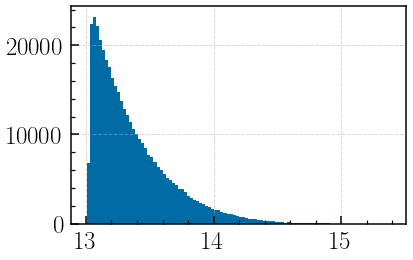

In [28]:
_ = plt.hist(np.log10(halo_cat['M200b']), bins=100)

In [86]:
10.98 - 0.561 * 14.06

3.092339999999999

In [96]:
alpha, pi = 0.7, 3.09
sigms = 0.15

logms = np.random.normal(loc=(alpha * np.log10(halo_cat['Mvir']) + pi), scale=sigms)

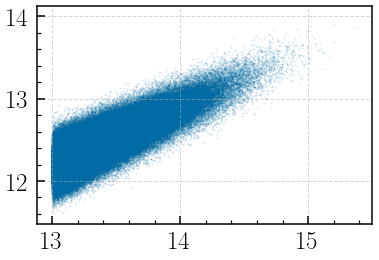

In [97]:
plt.scatter(np.log10(halo_cat['Mvir']), logms, alpha=0.1, s=1)

In [98]:
cat_m100 = Table()
cat_m100['logmh'] = np.log10(halo_cat['M200b'])
cat_m100['logms'] = logms
cat_m100.sort('logms')
cat_m100.reverse()

In [99]:
np.nanstd(cat_m100[rank_mdpl2[1]:rank_mdpl2[2]]['logmh'])

0.2102594269076395

In [100]:
lnN = np.random.normal(
    loc=mean_ln_N(halo_cat['M200b'], z=0.4), 
    scale=sig_ln_N(halo_cat['M200b'], z=0.4))

log10_N = np.log10(np.exp(lnN))

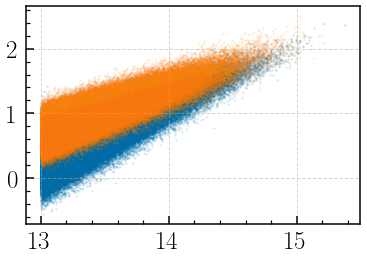

In [102]:
plt.scatter(np.log10(halo_cat['Mvir']), log10_N, s=2, alpha=0.1)
plt.scatter(np.log10(halo_cat['Mvir']), logms - 11.5, s=2, alpha=0.1)

In [81]:
cat_cam = Table()

cat_cam['logmh'] = np.log10(halo_cat['M200b'])
cat_cam['logn'] = log10_N
cat_cam.sort('logn')
cat_cam.reverse()

In [82]:
np.nanstd(cat_cam[rank_mdpl2[0]:rank_mdpl2[1]]['logmh'])

0.20692342083682516

In [83]:
np.nanstd(cat_cam[rank_mdpl2[1]:rank_mdpl2[2]]['logmh'])

0.2020456169679591

In [85]:
np.nanstd(cat_cam[rank_mdpl2[3]:rank_mdpl2[4]]['logmh'])

0.2277085645666012

In [6]:
# Pre-compute
hsc_pre = Table.read(os.path.join(data_dir, 's16a_massive_logm_11.2.fits'))

mask = (
    (hsc_pre['logm_10_100'] >= 9.5) & (hsc_pre['logm_max'] >= 11.2) & 
    (hsc_pre['logm_50_100'] >= 9.5) & (hsc_pre['bsm_s18a'])
)

data_use = hsc_pre[mask]

### Assign richness to halos 

- Based on the Mvir-richness relation of CAMIRA clusters from Murata et al. (2019)

- $P(\ln N \mid M, z)=\frac{1}{\sqrt{2 \pi} \sigma_{\ln N \mid M, z}} \exp \left(-\frac{x^{2}(N, M, z)}{2 \sigma_{\ln N \mid M, z}^{2}}\right)$

- $\begin{aligned} x(N, M, z) & \equiv \ln N-\left[A+B \ln \left(\frac{M}{M_{\text {pivot }}}\right)\right.\\ & \left.+B_{z} \ln \left(\frac{1+z}{1+z_{\text {pivot }}}\right)+C_{z}\left[\ln \left(\frac{1+z}{1+z_{\text {pivot }}}\right)\right]^{2}\right] \end{aligned}$

- $\begin{aligned} \sigma_{\ln N \mid M, z} &=\sigma_{0}+q \ln \left(\frac{M}{M_{\text {pivot }}}\right) \\ &+q_{z} \ln \left(\frac{1+z}{1+z_{\text {pivot }}}\right)+p_{z}\left[\ln \left(\frac{1+z}{1+z_{\text {pivot }}}\right)\right]^{2} \end{aligned}$

- Parameters for low-z ($0.1 < z < 0.4$) clusters using Planck cosmology:
    - $A = 3.34^{+0.25}_{-0.20}$
    - $B = 0.85^{+0.08}_{-0.07}$
    - $\sigma_0 = 0.36^{+0.07}_{-0.21}$
    - $q = -0.06^{0.09}_{-0.11}$
    
- Parameters for full redshift range using Planck cosmology:
    - $A = 3.15^{+0.07}_{-0.08}$
    - $B = 0.86^{+0.05}_{-0.05}$
    - $B_{z} = -0.21^{+0.35}_{-0.42}$
    - $C_{z} = 3.61^{+1.96}_{-2.23}$
    - $\sigma_0 = 0.32^{+0.06}_{-0.06}$
    - $q = -0.06^{+0.09}_{-0.11}$
    - $q_{z} = 0.03^{+0.31}_{-0.30}$
    - $p_{z} = 0.70^{+1.71}_{-1.60}$
    
- Pivot redshift and mass
    - $M_{\rm Pivot} = 3\times 10^{14} h^{-1} M_{\odot}$
    - $z_{\rm Pivot} = 0.6$
  
- Here, $M \equiv M_{200m}$ and $h=0.68$.

In [15]:
def mean_ln_N(m200m, z=None, m_pivot=3e14, h=0.68, A=3.15, B=0.86, 
              z_pivot=0.6, B_z=-0.21, C_z=3.61):
    """
    Estimate the mean ln(N) for CAMIRA clusters based on the halo mass-richness
    relation calibrated by Murata et al. (2019).
    """
    lnN = A + B * np.log(m200m / m_pivot / h)
    
    if z is None:
        return lnN
    
    z_term = np.log((1 + z) / (1 + z_pivot))
    
    return lnN + B_z * z_term + C_z * (z_term ** 2)

In [18]:
def sig_ln_N(m200m, z=None, m_pivot=3e14, h=0.68, sig0=0.32, z_pivot=0.6,
             q=-0.06, q_z=0.03, p_z=0.70):
    """
    Estimate the scatter of ln(N) for CAMINRA clusters based on the halo mass-richness
    relation calibrated by Murata et al. (2019).
    """
    sig_lnN = sig0 + q * np.log(m200m / m_pivot / h)
    
    if z is None:
        return sig_lnN
    
    z_term = np.log((1 + z) / (1 + z_pivot))
    
    return sig_lnN + q_z * z_term + p_z * (z_term ** 2)

In [7]:
from colossus.halo import mass_defs

In [20]:
mvir = 10.0 ** (data_use['logmh_vir_plane'])
z = data_use['z_best']

In [23]:
lnN = np.random.normal(loc=mean_ln_N(mvir, z=z), scale=sig_ln_N(mvir, z=z))

log10_N = np.log10(np.exp(lnN))

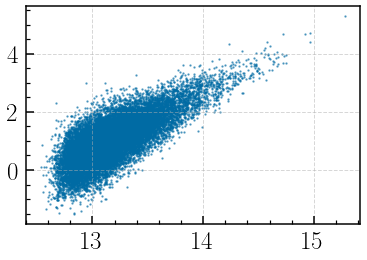

In [24]:
plt.scatter(data_use['logmh_vir_plane'], lnN, s=2, alpha=0.5)

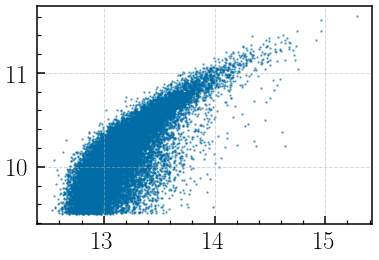

In [25]:
plt.scatter(data_use['logmh_vir_plane'], data_use['logm_50_100'], s=2, alpha=0.5)

In [4]:
from jianbing import scatter

In [5]:
def sigo_to_sigm(sigo, alpha=1.0, beta2=2.959):
    """Convert the scatter of observable to the scatter of halo mass."""
    return sigo / np.sqrt(beta2 * (sigo ** 2) + (alpha ** 2))

In [25]:
sigo_to_sigm(0.3, alpha=0.5, beta2=2.959)

0.4175091390561479

In [19]:
sigo_to_sigm(0.15, alpha=0.56, beta2=2.959)

0.24327532073818703

In [7]:
1 / 1.3

0.7692307692307692